### **Notebook 03: Semantic Presence Detection and Triage**

To query stimulus images from the CAT2000 dataset to produce deterministic, image-level semantic flags indicating the presence of humans, faces, and hands. These flags are then used to define triage sets and generate a task list for the segmentation pipeline in Notebook 04.

By performing checks at the image level preserves the full spatial context of the scene. The use of a constrained grammar for the vision-language model (VLM) ensures that the outputs are machine-readable, reproducible, and auditable. A foreground-gating step, requiring a human to be clearly visible before querying for faces or hands, reduces false positives from heavily occluded or distant figures.

An index of all stimulus images in the three anthropomorphic categories (Action, Affective, Social) is created. Each image is then passed to a locally hosted VLM, which answers a sequence of boolean questions (`has_human`, `human_visible`, etc.) using a fixed grammar and decoding settings. The resulting presence flags are saved and summarized. Finally, these flags are used to generate triage sets for analysis and a list of prompts for the segmentation model.

---

### **Section 0: Setup and Configuration**

In [9]:
# --- Section 0: Setup and Configuration ---

# --- Notebook-specific constants ---
NOTEBOOK_NUM = 3

# --- Standard libraries and third-party imports ---
import base64
import csv
import io
import json
import os
import random
import sys
from pathlib import Path
from typing import Optional, Dict, List, Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm

# --- Project-specific imports and configuration ---
# This assumes the notebook is in notebooks/ and config.py is in src/
sys.path.insert(0, str(Path("../src").resolve()))
import config

# --- Helper Functions ---

def get_output_path(section_num: int, filename: str) -> Path:
    """Generates a standardized output path for notebook artifacts."""
    output_dir = config.RESULTS_DIR / f"notebook{NOTEBOOK_NUM:02d}" / f"section{section_num:02d}"
    output_dir.mkdir(parents=True, exist_ok=True)
    return output_dir / filename

def enforce_category_order(df: pd.DataFrame, col: str = "category") -> pd.DataFrame:
    """Casts a column to the canonical categorical ordering and returns a sorted copy."""
    if col in df.columns:
        dtype = pd.CategoricalDtype(config.CAT_ORDER, ordered=True)
        out = df.copy()
        out[col] = out[col].astype(dtype)
        return out.sort_values(col)
    return df

def save_dataframe_as_markdown(df: pd.DataFrame, filepath: Path, title: str = ""):
    """Saves a DataFrame to Markdown with consistent numeric formatting."""
    df_to_write = df.copy()

    def _fmt_float(x: float) -> str:
        if pd.isna(x):
            return ""
        if 0 < abs(x) < 0.001:
            return f"{x:.2e}"
        return f"{x:.3f}"

    df_fmt = enforce_category_order(df_to_write)
    for col in df_fmt.select_dtypes(include=[float]).columns:
        df_fmt[col] = df_fmt[col].map(_fmt_float)

    with open(filepath, "w", encoding="utf-8") as f:
        if title:
            f.write(f"## {title}\n\n")
        f.write(df_fmt.to_markdown(index=False))
    print(f"[saved] {filepath}")

# --- Environment Setup ---
# Set pandas display options
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

# Set random seeds for reproducibility
random.seed(config.RANDOM_SEED)
np.random.seed(config.RANDOM_SEED)

# --- Configuration Snapshot ---
print("[config] Project configuration")
for key, value in sorted({k: v for k, v in config.__dict__.items() if k.isupper() and not k.startswith("_")}.items()):
    print(f"{key:<24}: {value}")

print("\n[ok] Setup complete.")

[config] Project configuration
ANTHROPOMORPHIC_CATEGORIES: ['Action', 'Affective', 'Social']
BOXPLOT_WIDTH           : 0.45
CAT2000_DIR             : /home/nico/Projects/final_project/data/CAT2000/trainSet
CATEGORIES              : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CATEGORY_COLORS         : {'Action': '#7ad151', 'Affective': '#414487', 'Social': '#fde725', 'Indoor': '#22a884', 'OutdoorManMade': '#2a7886', 'OutdoorNatural': '#440154'}
CATEGORY_ORDER          : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CATEGORY_PALETTE        : ['#7ad151', '#414487', '#fde725', '#22a884', '#2a7886', '#440154']
CAT_ORDER               : ['Action', 'Affective', 'Social', 'Indoor', 'OutdoorManMade', 'OutdoorNatural']
CENTER_BIAS_SIGMA_X_FRAC: 0.3
CENTER_BIAS_SIGMA_Y_FRAC: 0.3
DATA_DIR                : /home/nico/Projects/final_project/data
DBSCAN_EPS              : 60
DBSCAN_MIN_SAMPLES      : 15
DEFAULT_DECIMALS        : 3


---

### **Section 1: Grammar-Constrained Image-Level Presence Detection**

**Objective**

To identify, for each stimulus image, whether it contains a human, whether any human is in the foreground and clearly visible, and if so, whether a face or hand is visible. These determinations are made with a deterministic, grammar-constrained interaction with a local vision-language model (VLM). The resulting presence flags are used to define triage sets and to select prompts for segmentation in Notebook 04.

**Rationale**

By questioning at the image level rather than the ROI level, the method avoids compounding errors from ROI detection and preserves the full spatial context of the scene. A narrow boolean grammar ensures that outputs are machine-readable, reproducible, and auditable. A foreground-visibility gate reduces false positives from tiny, heavily occluded, or background humans that are not relevant to the study’s focus.

**Design Principles**

1.  **Full-scene context**: The entire stimulus image is provided to the model without cropping to preserve context and scale cues.
2.  **Foreground gating**: Questions about faces and hands are asked only if the image contains at least one human in the foreground who is clearly visible and not heavily occluded.
3.  **Determinism**: Decoding settings and the project seed are fixed to eliminate non-deterministic variability.
4.  **Parsimony**: Only attributes required for downstream triage and segmentation prompt selection are recorded.

**Attributes and Mapping**

| Attribute | Operational definition | LangSAM prompt | Notes |
| :--- | :--- | :--- | :--- |
| `has_human` | At least one human present anywhere in the image. | `person` | Top-level flag that enables subsequent queries. |
| `human_visible` | At least one human in the foreground, clearly visible, and not heavily occluded. | N/A | Required to trigger face/hand questions. |
| `has_face` | At least one human face visible in the foreground human(s). | `face` | N/A |
| `has_hand` | At least one human hand visible in the foreground human(s). | `hand` | N/A |

**Decision Process**

For each image in the Affective, Social, and Action categories, the following sequence is applied using a strict boolean grammar:

```
Q1: Does the image contain a human? → {"has_human": true|false}
    If true:
        Q2: Is at least one human in the foreground and clearly visible? → {"human_visible": true|false}
            If true:
                Q3: Is at least one face visible on a foreground human?  → {"has_face": true|false}
                Q4: Is at least one hand visible on a foreground human?  → {"has_hand": true|false}
```

**Prerequisite**

A local `llama.cpp` server must be running to serve Qwen2.5-VL for image and text annotation. The server loads the quantized model and multimodal projector and exposes an HTTP API that the notebook will call. The server address must match `"http://127.0.0.1:8080/v1/chat/completions"`.

**Instructions**

1.  Open a new terminal and activate the project environment:
    ```bash
    conda activate gaze-project
    ```
2.  Start the server with the project’s model paths:
    ```bash
    # Paths
    PROJECT_ROOT="$HOME/Projects/final_project"
    MODEL_PATH="$PROJECT_ROOT/models/qwen/Qwen_Qwen2.5-VL-7B-Instruct-Q4_K_M.gguf"
    MMPROJ_PATH="$PROJECT_ROOT/models/qwen/mmproj-Qwen_Qwen2.5-VL-7B-Instruct-f16.gguf"

    # Launch
    "$PROJECT_ROOT/llama.cpp/build/bin/llama-server" \
      -m "$MODEL_PATH" \
      --mmproj "$MMPROJ_PATH" \
      -ngl 99 \
      --host 127.0.0.1 \
      --port 8080
    ```

In [5]:
# --- Section 1: Grammar-Constrained Image-Level Presence Detection ---

def _collect_image_index() -> pd.DataFrame:
    """
    Builds a deterministic index of stimulus images for the three social categories.

    Returns:
        pd.DataFrame: A table with columns ['category', 'filename', 'image_path'],
                      where image_path is relative to the project root.
    """
    rows = []
    for cat in config.CATEGORY_ORDER:
        if cat not in config.ANTHROPOMORPHIC_CATEGORIES:
            continue
        cat_dir = Path(config.STIMULI_DIR) / cat
        if not cat_dir.exists():
            print(f"[warn] Missing category directory: {cat_dir}")
            continue
        for p in sorted(cat_dir.glob("*.jpg")):
            rows.append({
                "category": cat,
                "filename": p.name,
                "image_path": str(p.relative_to(config.PROJECT_ROOT)),
            })
    return pd.DataFrame(rows, columns=["category", "filename", "image_path"])

def _encode_image_to_data_url(image_path: Path) -> str:
    """Encodes an image file to a base64 data URL for API submission."""
    with Image.open(image_path).convert("RGB") as im:
        buf = io.BytesIO()
        im.save(buf, format="PNG")
    b64 = base64.b64encode(buf.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{b64}"

def _call_vlm_boolean(server_url: str, image_data_url: str, question: str,
                      grammar_text: str, timeout: int = 90) -> Optional[bool]:
    """
    Asks a single boolean question with grammar validation.

    Returns:
        True, False, or None on failure.
    """
    system_prompt = {
        "role": "system",
        "content": "You are a precise visual analysis assistant. Respond only with a valid JSON object."
    }
    user_prompt = {
        "role": "user",
        "content": [
            {"type": "image_url", "image_url": {"url": image_data_url}},
            {"type": "text", "text": f"{question}\nRespond only with JSON containing a single boolean field."},
        ],
    }
    payload = {
        "messages": [system_prompt, user_prompt], "grammar": grammar_text,
        "temperature": 0.0, "top_k": 1, "top_p": 1.0, "repeat_penalty": 1.0,
        "seed": config.RANDOM_SEED, "max_tokens": 64,
    }

    try:
        r = requests.post(server_url, json=payload, timeout=timeout)
        r.raise_for_status()
        raw = r.json()["choices"][0]["message"]["content"]
        start = raw.find("{")
        if start == -1: return None
        obj = json.loads(raw[start:])
        if isinstance(obj, bool): return obj
        if isinstance(obj, dict):
            for v in obj.values():
                if isinstance(v, bool): return v
    except requests.RequestException as e:
        tqdm.write(f"[warn] VLM request failed: {type(e).__name__} - {e}")
    except (json.JSONDecodeError, KeyError):
        tqdm.write(f"[warn] VLM returned non-JSON or unexpected schema.")
    return None

def _to_csv_tristate(val: Optional[bool]) -> str | int:
    """Converts a boolean or None to a CSV-compatible tri-state value."""
    return "" if val is None else (1 if val else 0)

# --- Main analysis function ---
def detect_image_level_presence():
    """
    Determines presence of humans, faces, and hands for each image.
    This function is idempotent and will resume if a partial output file is found.
    """
    print("[step] Building canonical image index...")
    index_df = _collect_image_index()
    if index_df.empty:
        print("[warn] No images found under the selected categories. Aborting.")
        return

    index_df = enforce_category_order(index_df.sort_values(["category", "filename"]))
    print(f"[info] Image index ready: {len(index_df)} images across {index_df['category'].nunique()} categories.")

    out_csv = get_output_path(1, "tbl_image_presence.csv")
    
    processed_keys = set()
    if out_csv.exists() and os.path.getsize(out_csv) > 0:
        try:
            done = pd.read_csv(out_csv, dtype={"category": str, "filename": str})
            processed_keys = set(zip(done["category"], done["filename"]))
            print(f"[info] Resuming from existing presence file with {len(done)} rows.")
        except Exception as e:
            print(f"[warn] Could not read existing presence file: {e}. A new file will be written.")

    mask_todo = ~index_df.apply(lambda r: (r["category"], r["filename"]) in processed_keys, axis=1)
    todo = index_df[mask_todo].reset_index(drop=True)

    if todo.empty:
        print("[info] All images already processed.")
        return

    try:
        bool_grammar = config.GRAMMAR_FILES["boolean"].read_text()
    except Exception as e:
        print(f"[error] Boolean grammar not available: {e}. Aborting.")
        return

    fieldnames = ["category", "filename", "image_path", "has_human", "human_visible", "has_face", "has_hand"]
    write_header = not out_csv.exists() or os.path.getsize(out_csv) == 0

    print(f"[step] Processing {len(todo)} images...")
    with open(out_csv, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        if write_header:
            writer.writeheader()

        for _, row in tqdm(todo.iterrows(), total=len(todo)):
            abs_path = config.PROJECT_ROOT / row["image_path"]
            if not abs_path.exists():
                tqdm.write(f"[warn] Missing file: {abs_path}")
                continue
            
            data_url = _encode_image_to_data_url(abs_path)
            
            # Perform sequential, gated VLM queries
            has_human = _call_vlm_boolean("http://127.0.0.1:8080/v1/chat/completions", data_url, "Does the image contain at least one human? Answer true or false.", bool_grammar)
            
            human_visible = None
            if has_human:
                human_visible = _call_vlm_boolean("http://127.0.0.1:8080/v1/chat/completions", data_url, "Is at least one human in the foreground and clearly visible? Answer true or false.", bool_grammar)

            has_face, has_hand = None, None
            if human_visible:
                has_face = _call_vlm_boolean("http://127.0.0.1:8080/v1/chat/completions", data_url, "Can a human face be clearly seen in the image foreground? Answer true or false.", bool_grammar)
                has_hand = _call_vlm_boolean("http://127.0.0.1:8080/v1/chat/completions", data_url, "Can a human hand be clearly seen in the image foreground? Answer true or false.", bool_grammar)

            writer.writerow({
                "category": row["category"], "filename": row["filename"], "image_path": row["image_path"],
                "has_human": _to_csv_tristate(has_human), "human_visible": _to_csv_tristate(human_visible),
                "has_face": _to_csv_tristate(has_face), "has_hand": _to_csv_tristate(has_hand),
            })
            f.flush()

    print(f"\n[info] Output saved to: {out_csv}")

# --- Execute Analysis ---
detect_image_level_presence()

[step] Building canonical image index...
[info] Image index ready: 300 images across 3 categories.
[info] Resuming from existing presence file with 300 rows.
[info] All images already processed.


---

### **Section 2: Presence Summary and Sanity Checks**

**Objective**

To summarize the image-level presence flags generated in Section 1 (`has_human`, `human_visible`, `has_face`, `has_hand`) and to verify their internal coherence before they are used to define analysis cohorts.

**Methodology**

The analysis loads the `tbl_image_presence.csv` file and computes two sets of summaries:

1.  **Global frequencies**: Calculates the total counts and proportions for each presence flag across all images.
2.  **Category-wise frequencies**: Calculates the same metrics, but broken down by the three categories. A coherence check is performed to ensure no images are flagged with `has_face` or `has_hand` without also being flagged as `has_human`.

**Inputs**

*   `results/notebook03/section01/tbl_image_presence.csv`: The validated presence flags generated in the previous section.

**Outputs**

*   `results/notebook03/section02/tbl_presence_summary_global.csv`: Tables summarizing the global prevalence of each semantic flag.
*   `results/notebook03/section02/tbl_presence_summary_by_category.csv`: Tables summarizing the prevalence of flags for each category.
*   `results/notebook03/section02/fig_presence_summary_combined.png`: A combined figure showing global and category-wise distributions.

[info] Reading presence file: /home/nico/Projects/final_project/results/notebook03/section01/tbl_image_presence.csv
[info] Presence data loaded: 300 images across 3 categories.
[saved] /home/nico/Projects/final_project/results/notebook03/section02/tbl_presence_coherence_violations.md
[saved] /home/nico/Projects/final_project/results/notebook03/section02/tbl_presence_summary_global.md
[saved] /home/nico/Projects/final_project/results/notebook03/section02/tbl_presence_summary_by_category.md

[table] Global Presence Summary


metric  count  n_valid  prop_all  prop_valid
0      has_human    276      300     0.920       0.920
1  human_visible    258      276     0.860       0.935
2       has_face    160      258     0.533       0.620
3       has_hand    125      258     0.417       0.484


[table] Category-wise Presence Summary


category  images  has_human  human_visible  has_face  has_hand  has_human_valid  human_visible_valid  has_face_valid  has_hand_valid  has_human_prop_all  has_human_prop_valid  human_visible_prop_all  human_visible_prop_valid  has_face_prop_all  has_face_prop_valid  has_hand_prop_all  has_hand_prop_valid
0     Action     100         99             83        39        40              100                   99              83              83                0.99                  0.99                    0.83                     0.838               0.39                0.470               0.40                0.482
1  Affective     100         77             76        56        36              100                   77              76              76                0.77                  0.77                    0.76                     0.987               0.56                0.737               0.36                0.474
2     Social     100        100             99        65        49              100                  100              99              99                1.00                  1.00                    0.99                     0.990               0.65                0.657               0.49                0.495


[info] Coherence checks:
  - Face is True & Human is False violations: 0
  - Hand is True & Human is False violations: 0
  - Visible is True & Human is False violations: 0


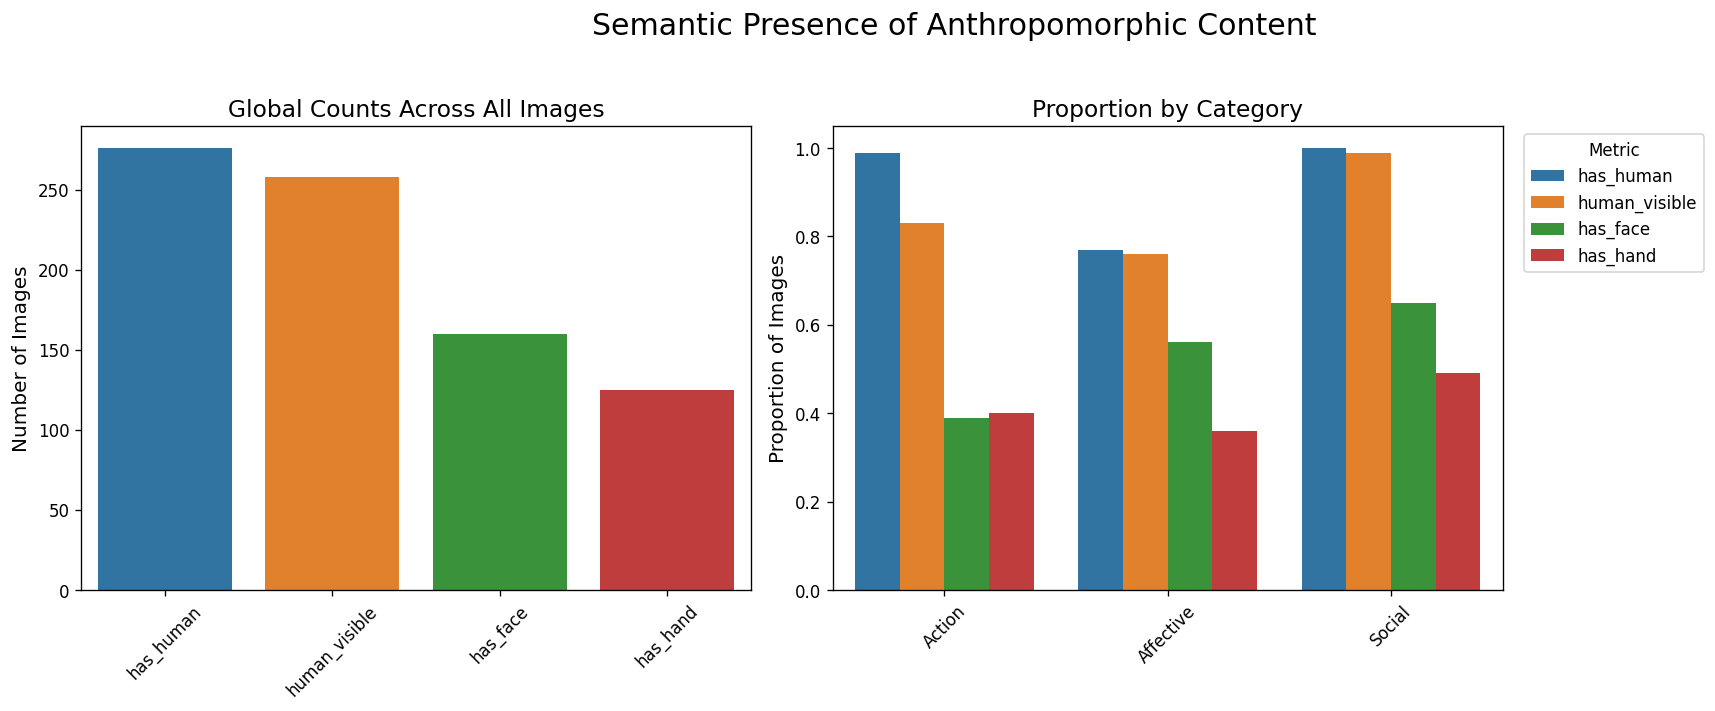

[saved] /home/nico/Projects/final_project/results/notebook03/section02/fig_presence_summary_combined.png


In [10]:
# --- Section 2: Presence Summary and Sanity Checks ---

def _load_presence_flags(path: Path) -> pd.DataFrame:
    """
    Loads image-level presence flags and preserves tri-state values.
    Flags are kept as floats {1.0, 0.0, NaN} to allow valid-only denominators downstream.
    """
    print(f"[info] Reading presence file: {path}")
    if not path.exists():
        raise FileNotFoundError(f"[error] Missing presence file: {path}")

    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    expected = {"category", "filename", "image_path", "has_human", "human_visible", "has_face", "has_hand"}
    missing = expected - set(df.columns)
    assert not missing, f"[error] Missing columns in presence file: {missing}"

    # Preserve tri-state: convert to numeric with NaN for non-numeric
    flag_cols = ["has_human", "human_visible", "has_face", "has_hand"]
    for c in flag_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # Restrict scope and enforce canonical order
    df = df[df["category"].isin(config.ANTHROPOMORPHIC_CATEGORIES)].copy()
    df = enforce_category_order(df)

    # Safety: ensure one row per image
    df = df.drop_duplicates(subset=["category", "filename"], keep="last").reset_index(drop=True)

    print(f"[info] Presence data loaded: {len(df)} images across {df['category'].nunique()} categories.")
    return df


def summarize_presence_flags():
    """
    Summarizes image-level presence flags and saves summary artifacts.
    """
    presence_path = get_output_path(1, "tbl_image_presence.csv")
    df = _load_presence_flags(presence_path)

    flag_cols = ["has_human", "human_visible", "has_face", "has_hand"]
    n_images = len(df)

    # --- Coherence checks ---
    # A violation is when a sub-category is True (1) but the parent is explicitly False (0).
    # NaNs in the parent category are not considered violations.
    viol_human_face = int(((df["has_face"] == 1) & (df["has_human"] == 0)).sum())
    viol_human_hand = int(((df["has_hand"] == 1) & (df["has_human"] == 0)).sum())
    viol_visible    = int(((df["human_visible"] == 1) & (df["has_human"] == 0)).sum())
    
    # Save coherence audit
    coh_df = pd.DataFrame([{
        "face_without_human": viol_human_face,
        "hand_without_human": viol_human_hand,
        "visible_without_human": viol_visible
    }])
    coh_csv = get_output_path(2, "tbl_presence_coherence_violations.csv")
    coh_md = get_output_path(2, "tbl_presence_coherence_violations.md")
    coh_df.to_csv(coh_csv, index=False)
    save_dataframe_as_markdown(coh_df, coh_md, title="Presence Coherence Violations")

    # --- Global Summary ---
    counts = {c: int((df[c] == 1).sum()) for c in flag_cols}
    n_valid = {c: int(df[c].notna().sum()) for c in flag_cols}

    global_summary = pd.DataFrame({
        "metric": flag_cols, "count": [counts[c] for c in flag_cols],
        "n_valid": [n_valid[c] for c in flag_cols]
    }).assign(
        prop_all=lambda d: (d["count"] / n_images),
        prop_valid=lambda d: np.where(d["n_valid"] > 0, d["count"] / d["n_valid"], np.nan)
    )
    
    global_csv = get_output_path(2, "tbl_presence_summary_global.csv")
    global_md = get_output_path(2, "tbl_presence_summary_global.md")
    global_summary.to_csv(global_csv, index=False)
    save_dataframe_as_markdown(global_summary, global_md, title="Global Presence Summary")

    # --- Category-wise Summary ---
    agg = df.groupby("category", observed=True).agg(
        images=("filename", "nunique"),
        has_human=("has_human", lambda s: int((s == 1).sum())),
        human_visible=("human_visible", lambda s: int((s == 1).sum())),
        has_face=("has_face", lambda s: int((s == 1).sum())),
        has_hand=("has_hand", lambda s: int((s == 1).sum())),
        has_human_valid=("has_human", lambda s: int(s.notna().sum())),
        human_visible_valid=("human_visible", lambda s: int(s.notna().sum())),
        has_face_valid=("has_face", lambda s: int(s.notna().sum())),
        has_hand_valid=("has_hand", lambda s: int(s.notna().sum())),
    ).reset_index()

    for col in flag_cols:
        agg[f"{col}_prop_all"] = (agg[col] / agg["images"])
        denom = agg[f"{col}_valid"].replace(0, np.nan)
        agg[f"{col}_prop_valid"] = (agg[col] / denom)
        
    cat_csv = get_output_path(2, "tbl_presence_summary_by_category.csv")
    cat_md = get_output_path(2, "tbl_presence_summary_by_category.md")
    agg.to_csv(cat_csv, index=False)
    save_dataframe_as_markdown(agg, cat_md, title="Presence Summary by Category")

    # --- Display Summaries ---
    print("\n[table] Global Presence Summary")
    _g = global_summary.copy()
    _g[["prop_all","prop_valid"]] = _g[["prop_all","prop_valid"]].round(3)
    display(_g)
    
    print("\n[table] Category-wise Presence Summary")
    _a = agg.copy()
    for c in [x for x in _a.columns if "prop" in x]:
        _a[c] = _a[c].round(3)
    display(_a)

    print("\n[info] Coherence checks:")
    print(f"  - Face is True & Human is False violations: {viol_human_face}")
    print(f"  - Hand is True & Human is False violations: {viol_human_hand}")
    print(f"  - Visible is True & Human is False violations: {viol_visible}")

    # --- Generate and Save Figures ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=config.FIG_DPI)
    fig.suptitle("Semantic Presence of Anthropomorphic Content", fontsize=18)
    
    # Panel 1: Global Counts
    sns.barplot(ax=axes[0], x="metric", y="count", data=global_summary, order=flag_cols, hue="metric", legend=False)
    axes[0].set_title("Global Counts Across All Images", fontsize=14)
    axes[0].set_xlabel(None)
    axes[0].set_ylabel("Number of Images", fontsize=12)
    axes[0].tick_params(axis='x', rotation=45)

    # Panel 2: Category Proportions (grouped)
    tidy = agg.melt(id_vars="category", value_vars=[f"{c}_prop_all" for c in flag_cols], 
                    var_name="metric", value_name="proportion")
    tidy["metric"] = tidy["metric"].str.replace("_prop_all", "")
    
    sns.barplot(ax=axes[1], data=tidy, x="category", y="proportion", hue="metric", 
                order=config.ANTHROPOMORPHIC_CATEGORIES, hue_order=flag_cols)
    axes[1].set_title("Proportion by Category", fontsize=14)
    axes[1].set_xlabel(None)
    axes[1].set_ylabel("Proportion of Images", fontsize=12)
    axes[1].legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    
    combo_png = get_output_path(2, "fig_presence_summary_combined.png")
    combo_svg = get_output_path(2, "fig_presence_summary_combined.svg")
    fig.savefig(combo_png, dpi=300)
    fig.savefig(combo_svg)
    plt.show()
    
    print(f"[saved] {combo_png}")

# --- Execute Analysis ---
summarize_presence_flags()

---

### **Section 3: Triage Set Construction**

**Objective**

To convert the image-level presence flags from Section 1 into deterministic triage sets for downstream analysis and to generate a segmentation task list for Notebook 04.

**Rationale**

This step formalizes the subsets of images that meet specific criteria (e.g., "contains both a face and a hand") for targeted analysis. It also translates the wide-format presence flags into a long-format task list, which is the required input format for the batch segmentation pipeline. This ensures that only relevant images are processed with the appropriate semantic prompts.

**Methodology**

The `tbl_image_presence.csv` file is loaded, and its tri-state flags are used to compute three boolean indicators for each image: `pair_FH` (face and hand present), `trio_FHP` (face, hand, and human present), and `any_anthropomorphic` (any human body elements present). A long-format task list is then generated, mapping each image to one or more segmentation prompts (`person`, `face`, `hand`) based on its flags.

**Inputs**

*   `results/notebook03/section01/tbl_image_presence.csv`: The validated presence flags generated in the previous section.

**Outputs**

*   `results/notebook03/section03/tbl_triage_sets.csv`: A table containing the final triage flags for each image.
*   `results/notebook03/section03/tbl_segmentation_task_list.csv`: A long-format list mapping each image to its required segmentation prompts.
*   `results/notebook03/section03/tbl_triage_summary.csv`: A summary of image counts for each triage set, both globally and by category.

In [9]:
# --- Section 3: Triage Set Construction ---

def build_triage_sets() -> None:
    """
    Builds image-level triage flags and a segmentation task list from the
    presence flags file and saves the results.
    """
    print("[step] Loading image-level presence flags...")
    inp_path = get_output_path(1, "tbl_image_presence.csv")
    if not inp_path.exists():
        print(f"[error] Missing input file: {inp_path}")
        return

    df = pd.read_csv(inp_path)
    df = enforce_category_order(df)

    # Preserve tri-state flags as numeric with NaN for missing
    flag_cols = ["has_human", "human_visible", "has_face", "has_hand"]
    for c in flag_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.drop_duplicates(subset=["category", "filename"]).reset_index(drop=True)
    print(f"[info] Presence flags loaded for {len(df)} images.")

    # --- Compute triage flags ---
    # Note: NaN is treated as False in boolean comparisons, which is the desired behavior.
    df["pair_FH"]  = ((df["has_face"] == 1) & (df["has_hand"] == 1)).astype(int)
    df["trio_FHP"] = ((df["has_face"] == 1) & (df["has_hand"] == 1) & (df["has_human"] == 1)).astype(int)
    df["any_anthropomorphic"] = ((df["has_human"] == 1) | (df["has_face"] == 1) | (df["has_hand"] == 1)).astype(int)

    # --- Sanity check ---
    pair_not_trio = int(((df["pair_FH"] == 1) & (df["trio_FHP"] == 0)).sum())
    if pair_not_trio > 0:
        print(f"[warn] {pair_not_trio} images flagged pair_FH but not trio_FHP (some may lack has_human flag).")
    else:
        print("[info] Sanity check passed: All images with face and hand also have human flag.")

    # --- Save triage sets ---
    triage_cols = ["category", "filename", "image_path", "has_human", "human_visible", 
                   "has_face", "has_hand", "pair_FH", "trio_FHP", "any_anthropomorphic"]
    triage_csv = get_output_path(3, "tbl_triage_sets.csv")
    triage_md = get_output_path(3, "tbl_triage_sets.md")
    df[triage_cols].to_csv(triage_csv, index=False)
    save_dataframe_as_markdown(df[triage_cols], triage_md, title="Triage Sets (Image-Level)")

    # --- Produce segmentation task list ---
    def _is_one(x) -> bool:
        return x == 1.0

    rows = []
    for _, r in df.iterrows():
        prompts = []
        if _is_one(r["has_human"]) or _is_one(r["human_visible"]): prompts.append("person")
        if _is_one(r["has_face"]): prompts.append("face")
        if _is_one(r["has_hand"]): prompts.append("hand")
        for p in prompts:
            rows.append({"category": r["category"], "filename": r["filename"], 
                         "image_path": r["image_path"], "prompt": p})

    task_df = pd.DataFrame(rows)
    task_csv = get_output_path(3, "tbl_segmentation_task_list.csv")
    task_md = get_output_path(3, "tbl_segmentation_task_list.md")
    task_df.to_csv(task_csv, index=False)
    save_dataframe_as_markdown(task_df, task_md, title="Segmentation Task List")

    # --- Compute and save summary tables ---
    summary_cat = df.groupby("category", observed=True).agg(
        images=("filename", "nunique"),
        pair_FH=("pair_FH", "sum"),
        trio_FHP=("trio_FHP", "sum"),
        any_anthropomorphic=("any_anthropomorphic", "sum")
    ).reset_index()

    summary_global = pd.DataFrame([{
    "category": "Global",
    "images": df.drop_duplicates(["category", "filename"]).shape[0],
    "pair_FH": int(df["pair_FH"].sum()),
    "trio_FHP": int(df["trio_FHP"].sum()),
    "any_anthropomorphic": int(df["any_anthropomorphic"].sum())}])

    summary = pd.concat([summary_global, summary_cat], ignore_index=True)
    summary_csv = get_output_path(3, "tbl_triage_summary.csv")
    summary_md = get_output_path(3, "tbl_triage_summary.md")
    summary.to_csv(summary_csv, index=False)
    save_dataframe_as_markdown(summary, summary_md, title="Triage Counts Summary")

    print("\n[table] Triage Counts (Global and by Category)")
    display(summary)
    

# --- Execute Analysis ---
build_triage_sets()

[step] Loading image-level presence flags...
[info] Presence flags loaded for 300 images.
[info] Sanity check passed: All images with face and hand also have human flag.
[saved] /home/nico/Projects/final_project/results/notebook03/section03/tbl_triage_sets.md
[saved] /home/nico/Projects/final_project/results/notebook03/section03/tbl_segmentation_task_list.md
[saved] /home/nico/Projects/final_project/results/notebook03/section03/tbl_triage_summary.md

[table] Triage Counts (Global and by Category)


category  images  pair_FH  trio_FHP  any_anthropomorphic
0     Global     300       95        95                  276
1     Action     100       24        24                   99
2  Affective     100       28        28                   77
3     Social     100       43        43                  100

---

### **Section 4: Stability Check and Seeded Qualitative Grid**

**Objective**

To verify that the image-level presence flags are reproducible under small inference perturbations and to provide a deterministic visual audit of the triage inputs.

**Rationale**

This analysis serves as a QC step. A seeded 5% subset of images is re-queried under two perturbation conditions. The seed toggle acts as a determinism sanity check, ensuring the decoding pipeline is stable. The JPEG re-encode serves as a robustness probe, testing the model's sensitivity to minor pixel-level variations. The resulting agreement rates quantify the stability of each flag, while a qualitative grid provides visual examples for audit.

**Methodology**

Presence flags are re-estimated on a seeded 5% subset of images using the same boolean grammar and gated logic from Section 1. Two perturbations are evaluated:

1.  **Seed toggle**: The decoding seed is changed (`RANDOM_SEED + 1`) while the input pixels remain identical.
2.  **JPEG re-encode**: The image is re-encoded as a JPEG with quality 70.

Agreement between the original flags (with `NaN` treated as `False`) and the perturbed flags is computed globally and per category. A grid of images is generated, overlaying the original presence flags for visual audit. 

**Inputs**

*   `results/notebook03/section01/tbl_image_presence.csv`: The original presence flags.
*   CAT2000 stimulus images for the Action, Affective, and Social categories.

**Outputs**

*   `results/notebook03/section04/tbl_presence_stability.csv`: Per-image agreement flags for both perturbation conditions.
*   `results/notebook03/section04/tbl_presence_stability_summary_global.csv`: A summary table of global agreement rates.
*   `results/notebook03/section04/tbl_presence_stability_summary_by_category.csv`: A summary table of category-wise agreement rates.
*   `results/notebook03/section04/tbl_presence_coherence_violations.csv`: A log of any coherence violations found.
*   `results/notebook03/section04/fig_presence_grid_combined.png`: A combined 3x6 grid for visual auditing.
*   `results/notebook03/section04/presence_grid/`: A directory containing individual panels from the audit grid.

[step] Starting stability check and visual audit...


Running stability queries: 100%|██████████| 15/15 [01:40<00:00,  6.70s/it]

[saved] /home/nico/Projects/final_project/results/notebook03/section04/tbl_presence_stability.md
[saved] /home/nico/Projects/final_project/results/notebook03/section04/tbl_presence_stability_summary.md

[table] Presence Stability Summary (Agreement in Percent)


metric   n  agree_seed  pct_agree_seed  agree_jpeg  pct_agree_jpeg
0      has_human  15          15         100.000          14          93.333
1  human_visible  15          15         100.000          14          93.333
2       has_face  15          15         100.000          14          93.333
3       has_hand  15          13          86.667          13          86.667


--- Visual Audit Grid ---
Grid annotations: H = has_human, V = human_visible, F = has_face, Hd = has_hand


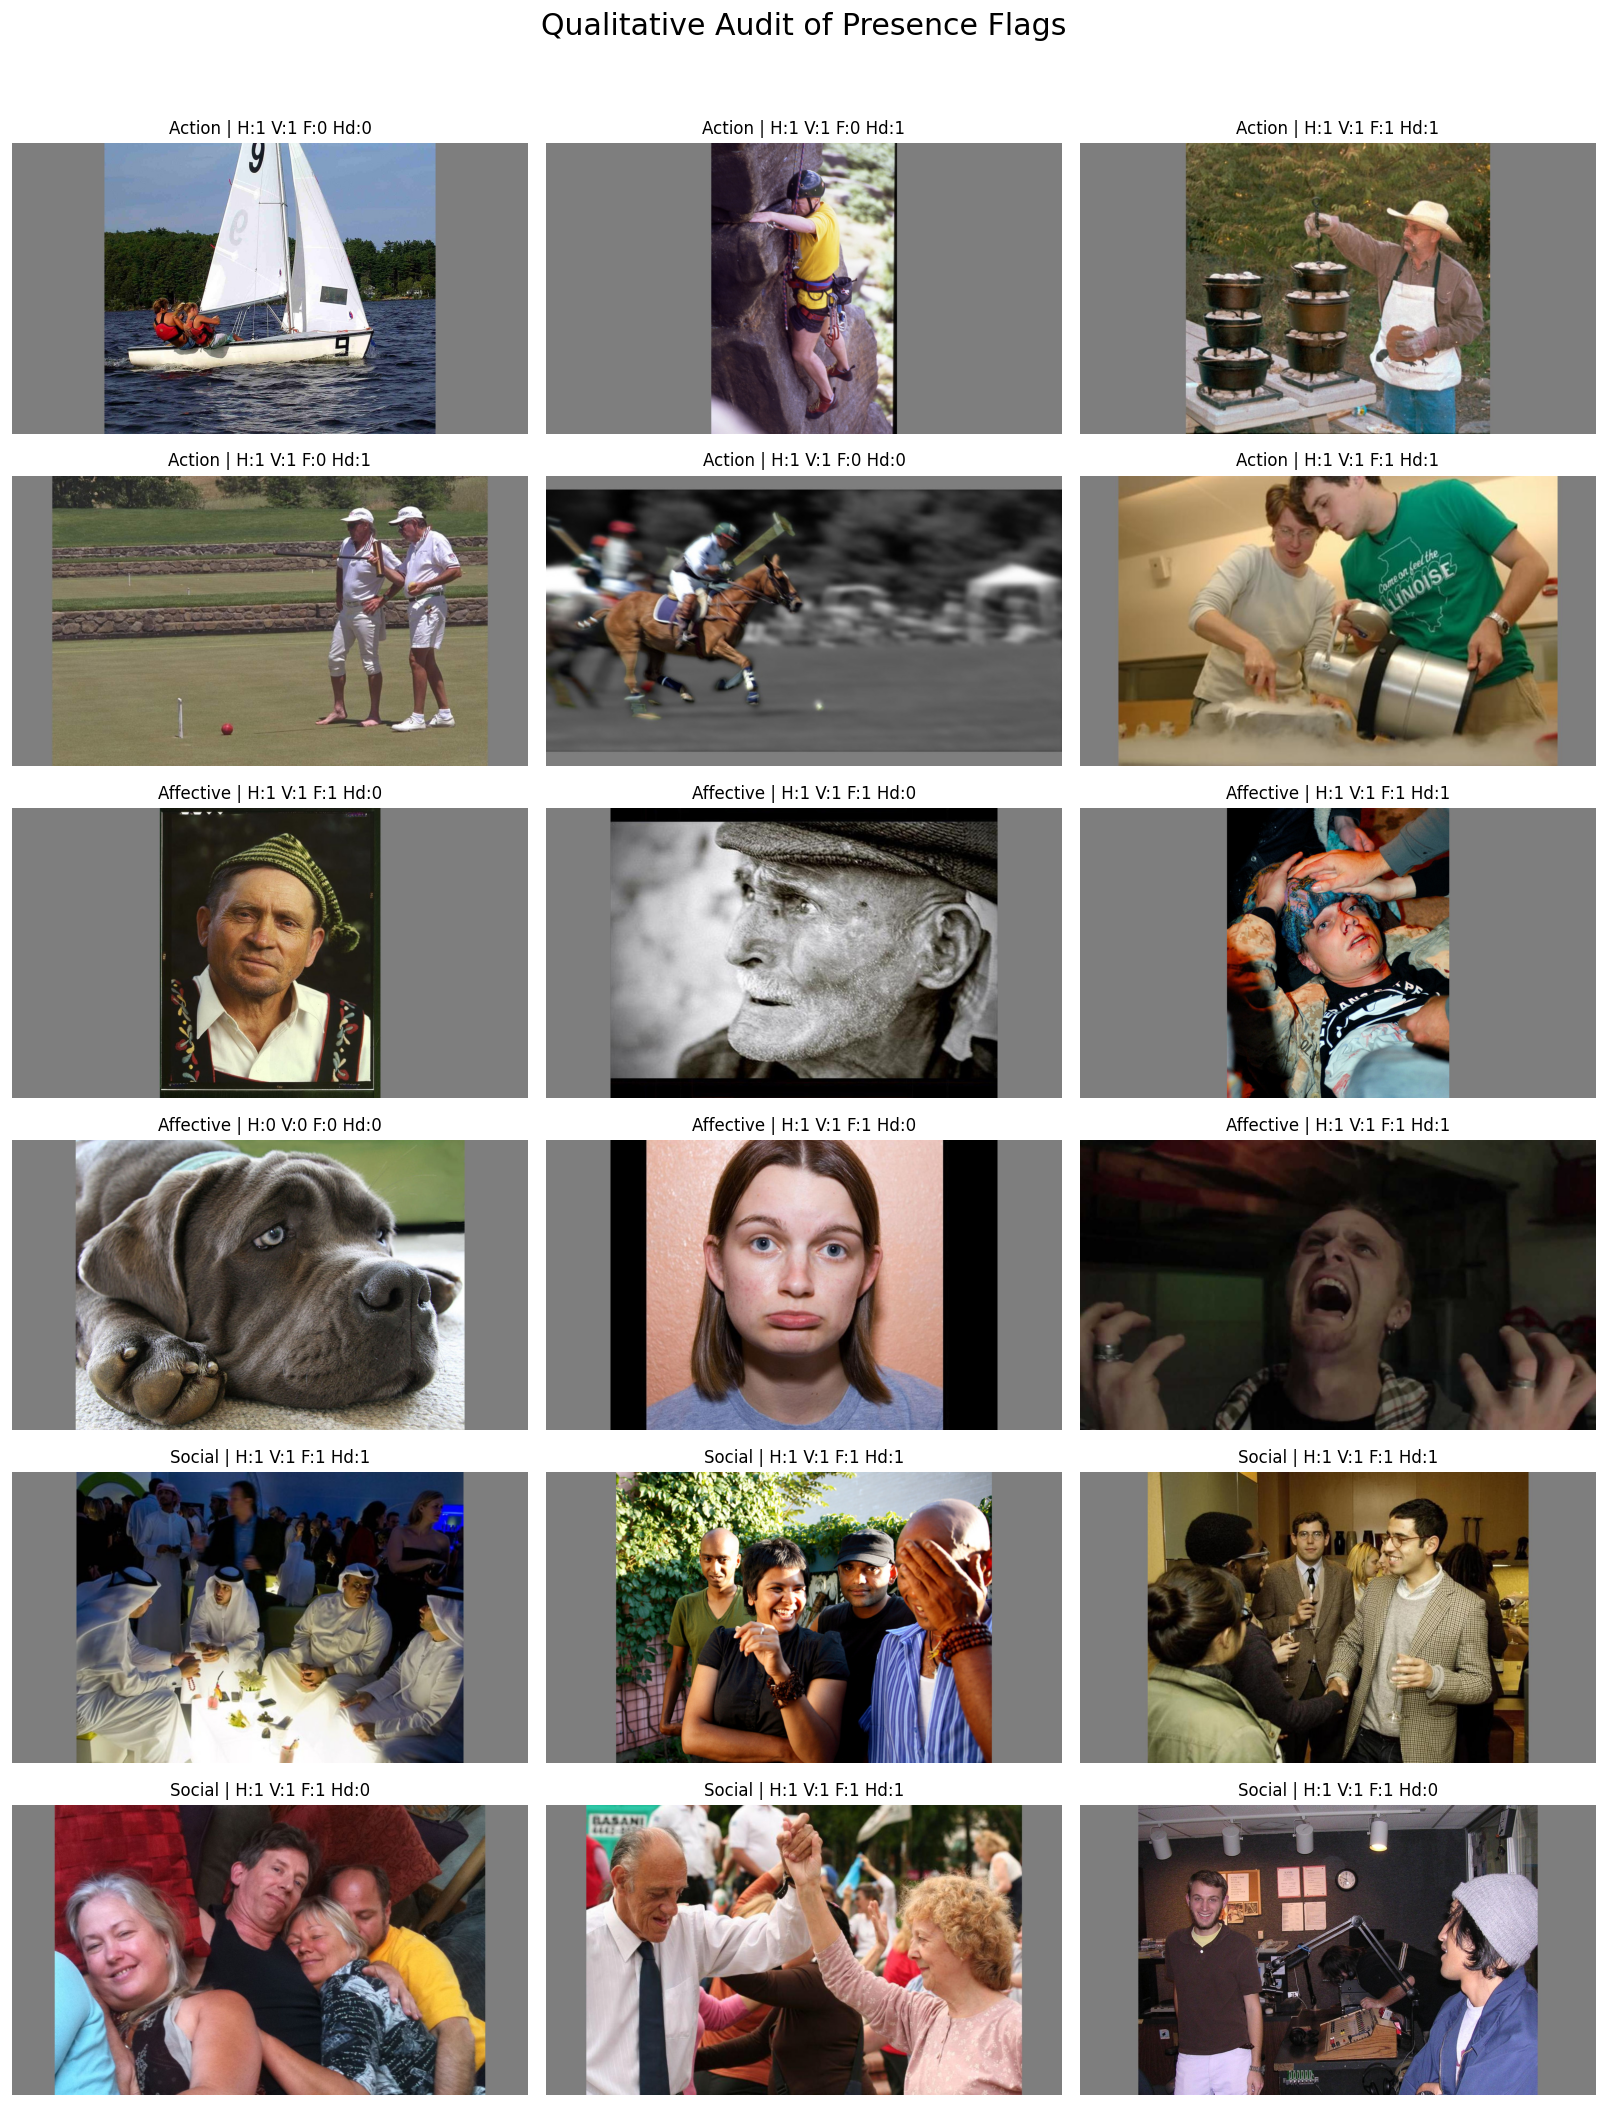

[saved] /home/nico/Projects/final_project/results/notebook03/section04/fig_presence_grid_combined.png


In [8]:
# --- Section 4: Stability Check and Seeded Qualitative Grid ---

def _encode_bytes_to_data_url(data: bytes, mime: str = "image/jpeg") -> str:
    """Encodes raw bytes to a base64 data URL."""
    b64 = base64.b64encode(data).decode("utf-8")
    return f"data:{mime};base64,{b64}"

def _query_presence_flags(data_url: str, bool_grammar: str, seed_offset: int = 0) -> Dict[str, int]:
    """
    Runs the full gated query sequence for a single image and returns integer flags.
    Mirrors the logic from Section 1 for a valid comparison.
    """
    # This function relies on _call_vlm_boolean being defined in a previous cell.
    original_config_seed = config.RANDOM_SEED
    config.RANDOM_SEED += seed_offset
    
    try:
        has_human = _call_vlm_boolean("http://127.0.0.1:8080/v1/chat/completions", data_url, "Does the image contain at least one human? Answer true or false.", bool_grammar)
        
        human_visible = None
        if has_human:
            human_visible = _call_vlm_boolean("http://127.0.0.1:8080/v1/chat/completions", data_url, "Is at least one human in the foreground and clearly visible? Answer true or false.", bool_grammar)

        has_face, has_hand = None, None
        if human_visible:
            has_face = _call_vlm_boolean("http://127.0.0.1:8080/v1/chat/completions", data_url, "Can a human face be clearly seen in the foreground? Answer true or false.", bool_grammar)
            has_hand = _call_vlm_boolean("http://127.0.0.1:8080/v1/chat/completions", data_url, "Can a human hand be clearly seen in the foreground? Answer true or false.", bool_grammar)
    finally:
        # Restore the original seed to avoid side effects
        config.RANDOM_SEED = original_config_seed

    return {
        "has_human": 1 if has_human else 0,
        "human_visible": 1 if human_visible else 0,
        "has_face": 1 if has_face else 0,
        "has_hand": 1 if has_hand else 0,
    }

def analyze_presence_stability_and_audit(seed_offset: int = 1, subset_frac: float = 0.05):
    """
    Performs stability checks and generates a visual audit grid for presence flags.
    """
    print("[step] Starting stability check and visual audit...")
    flag_cols = ["has_human", "human_visible", "has_face", "has_hand"]
    
    presence_csv_path = get_output_path(1, "tbl_image_presence.csv")
    if not presence_csv_path.exists():
        print(f"[error] Missing presence file: {presence_csv_path}")
        return

    df = pd.read_csv(presence_csv_path, dtype={"category": str, "filename": str})
    df = df[df["category"].isin(config.ANTHROPOMORPHIC_CATEGORIES)].copy()
    
    orig = df.drop_duplicates(subset=["category", "filename"]).copy()
    for c in flag_cols:
        orig[c] = pd.to_numeric(orig[c], errors="coerce").fillna(0).astype(int)

    # --- Stability Check ---
    rng = np.random.default_rng(config.RANDOM_SEED)
    k = max(6, int(subset_frac * len(orig)))
    subset = orig.sample(n=k, random_state=rng)

    try:
        bool_grammar = config.GRAMMAR_FILES["boolean"].read_text()
    except Exception as e:
        print(f"[error] Could not read boolean grammar: {e}. Aborting.")
        return

    rows = []
    for _, row in tqdm(subset.iterrows(), total=len(subset), desc="Running stability queries"):
        img_path = config.PROJECT_ROOT / row["image_path"]
        if not img_path.exists(): continue
        
        with Image.open(img_path) as im:
            data_url_orig = _encode_image_to_data_url(img_path)
            new_seed_flags = _query_presence_flags(data_url_orig, bool_grammar, seed_offset=seed_offset)
            buf = io.BytesIO()
            im.convert("RGB").save(buf, format="JPEG", quality=70)
            data_url_jpeg = _encode_bytes_to_data_url(buf.getvalue())
            new_jpeg_flags = _query_presence_flags(data_url_jpeg, bool_grammar)
        
        row_data = row.to_dict()
        row_data.update({f"new_seed_{k}": v for k, v in new_seed_flags.items()})
        row_data.update({f"new_jpeg_{k}": v for k, v in new_jpeg_flags.items()})
        rows.append(row_data)

    merged = pd.DataFrame(rows).rename(columns={c: f"old_{c}" for c in flag_cols})
    
    for flag in flag_cols:
        merged[f"agree_seed_{flag}"] = (merged[f"old_{flag}"] == merged[f"new_seed_{flag}"]).astype(int)
        merged[f"agree_jpeg_{flag}"] = (merged[f"old_{flag}"] == merged[f"new_jpeg_{flag}"]).astype(int)
    
    stable_csv = get_output_path(4, "tbl_presence_stability.csv")
    merged.to_csv(stable_csv, index=False)
    save_dataframe_as_markdown(merged, get_output_path(4, "tbl_presence_stability.md"), "Presence Stability (Per-Image)")

    # Summarize and save
    n = len(merged)
    summary_rows = []
    for flag in flag_cols:
        summary_rows.append({
            "metric": flag, "n": n,
            "agree_seed": merged[f"agree_seed_{flag}"].sum(),
            "pct_agree_seed": (merged[f"agree_seed_{flag}"].sum() / n * 100.0),
            "agree_jpeg": merged[f"agree_jpeg_{flag}"].sum(),
            "pct_agree_jpeg": (merged[f"agree_jpeg_{flag}"].sum() / n * 100.0)
        })
    summary = pd.DataFrame(summary_rows)
    sum_csv = get_output_path(4, "tbl_presence_stability_summary.csv")
    sum_md = get_output_path(4, "tbl_presence_stability_summary.md")
    summary.to_csv(sum_csv, index=False)
    save_dataframe_as_markdown(summary, sum_md, title="Presence Stability Summary")
    
    print("\n[table] Presence Stability Summary (Agreement in Percent)")
    _summary = summary.copy()
    if {"pct_agree_seed", "pct_agree_jpeg"}.issubset(_summary.columns):
        _summary[["pct_agree_seed", "pct_agree_jpeg"]] = _summary[["pct_agree_seed", "pct_agree_jpeg"]].round(3)
    display(_summary)

    # --- Visual Audit Grid ---
    grid_out_dir = get_output_path(4, "presence_grid")
    grid_out_dir.mkdir(parents=True, exist_ok=True)
    
    n_cols, n_rows = 3, len(config.ANTHROPOMORPHIC_CATEGORIES) * 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.0), dpi=config.FIG_DPI)
    
    for r, cat in enumerate(config.ANTHROPOMORPHIC_CATEGORIES):
        cat_df = orig[orig["category"] == cat].sample(6, random_state=config.RANDOM_SEED)
        
        for i, (_, row) in enumerate(cat_df.iterrows()):
            ax = axes[(r * 2) + (i // 3), i % 3]
            img_path = config.PROJECT_ROOT / row["image_path"]
            if img_path.exists():
                with Image.open(img_path) as im:
                    ax.imshow(im)
                    title = (f"{cat} | H:{row['has_human']} "
                             f"V:{row['human_visible']} "
                             f"F:{row['has_face']} "
                             f"Hd:{row['has_hand']}")
                    ax.set_title(title, fontsize=10)

                    panel_fig, panel_ax = plt.subplots(figsize=(4.5, 3.0), dpi=150)
                    panel_ax.imshow(im); panel_ax.axis("off"); panel_ax.set_title(title, fontsize=10)
                    fname = Path(row["filename"]).stem
                    panel_path = grid_out_dir / f"{cat}_{fname}.png"
                    panel_fig.tight_layout(); panel_fig.savefig(panel_path, dpi=150); plt.close(panel_fig)
            ax.axis("off")

    fig.suptitle("Qualitative Audit of Presence Flags", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    grid_png = get_output_path(4, "fig_presence_grid_combined.png")
    fig.savefig(grid_png, dpi=300)

    print("\n--- Visual Audit Grid ---")
    print("Grid annotations: H = has_human, V = human_visible, F = has_face, Hd = has_hand")
    plt.show()
    
    print(f"[saved] {grid_png}")

# --- Execute Analysis ---
analyze_presence_stability_and_audit()

**Results**

A seeded 5% subset of images (n=15) was re-queried under two perturbation conditions: a seed toggle and a JPEG re-encode at quality 70. Agreement was computed against the original, binarized flags (`NaN` -> 0).

The stability results show high but imperfect reproducibility. Under a simple seed toggle, agreement was 100% for `has_human`, `human_visible`, and `has_face`, but dropped to 86.7% for `has_hand`, indicating minor non-determinism in the decoding path for this specific flag. Under JPEG re-encoding, agreement was 93.3% for `has_human`, `human_visible`, and `has_face`, and 86.7% for `has_hand`.

The qualitative audit grid provides visual context for these results. For instance, the Affective and Social category rows show complex scenes with multiple, sometimes occluded, hands and faces where the model's decision might be sensitive to small changes. Conversely, the grid also confirms correct negative classifications, such as the animal-only image in the Affective row.

**Interpretation**

1.  **Determinism of the decoding path**: The seed-toggle check confirms that the image -> VLM -> label path is highly deterministic for coarse-grained flags. The 13.3% disagreement rate (2 out of 15 images) for `has_hand` suggests that this specific query operates near a decision boundary where minor variations in the decoding process can alter the outcome.

2.  **Sensitivity to small pixel perturbations**: The JPEG re-encoding shows that all flags exhibit some sensitivity to minor pixel changes. The coarse flags (`has_human`, `human_visible`) remain highly robust (93.3% agreement). The finer-grained flags (`has_face`, `has_hand`) show greater fragility, with disagreement rates of 6.7% and 13.3% respectively. This is consistent with the qualitative grid, where challenging cases often involve small, occluded, or low-contrast hands and faces in crowded scenes.

3.  **Effect on triage and downstream steps**:
    *   The high stability of the original flags means the triage sets remain valid for the current analysis; the stability check primarily serves as a robustness probe.
    *   The observed ~7-13% flip rate for `has_face` and `has_hand` under minor perturbation confirms that these flags should be treated as lower-confidence signals than `has_human`. This reinforces the need for the instance-level QC planned in Notebook 04, which will validate masks directly rather than relying solely on these image-level flags.
    *   The stability results support including a limitation in the final report: presence indicators for small features like faces and hands are more fragile than indicators for general human presence.

4.  **Reporting Guidance**:
    *   The stability acceptance threshold of 95% agreement is met by `has_human`, `human_visible`, and `has_face` under a seed toggle but is not met by `has_hand`. Under JPEG perturbation, none of the flags meet the 95% threshold. This finding should be stated explicitly in any limitations section.
    *   The qualitative grid provides transparent visual examples that support the quantitative results and can be used to illustrate representative success and failure cases in a final report.

**Conclusion**

Presence detection is highly reproducible with fixed decoding and robust for coarse, human-level questions. The finer-grained flags for faces and especially hands are more sensitive to both deterministic variability and minor input perturbations. This is particularly true in complex scenes with small or partially occluded features. The downstream QC and detector-agreement checks in Notebook 04 are designed to absorb this fragility before the primary analyses in Notebook 05, which will be conditioned on the resulting high-confidence curated cohorts.